# 1.0 Full Exploratory Data Analysis

## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import final_project.utils.paths as path
import janitor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Download data

### Specify input and output files

In [3]:
covid_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

covid_file = path.data_raw_dir("time_series_covid19_confirmed_global.csv")

### Run download

In [4]:
!curl {covid_url} -o {covid_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  887k  100  887k    0     0  1815k      0 --:--:-- --:--:-- --:--:-- 1811k


## Process data

### Read data

In [5]:
input_covid_file = path.data_raw_dir("time_series_covid19_confirmed_global.csv")

In [6]:
covid_df = pd.read_csv(input_covid_file)
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Columns: 656 entries, Province/State to 11/3/21
dtypes: float64(2), int64(652), object(2)
memory usage: 1.4+ MB


In [7]:
covid_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,156040,156071,156124,156166,156196,156210,156250,156284,156307,156323
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,181960,182610,183282,183873,184340,184887,185300,185497,186222,186793
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,205903,205990,206069,206160,206270,206358,206452,206566,206649,206754
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15425,15425,15462,15505,15516,15516,15516,15516,15516,15572
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,63930,64033,64126,64226,64301,64374,64433,64458,64487,64533


### Process data

In [8]:
processed_df = (
    covid_df
    .select_columns(["Country/Region", "*/*/*"])
    .pivot_longer(
        index="Country/Region",
        names_to="date"
    )
    .transform_column("date", pd.to_datetime)
    .clean_names()
)

processed_df.head()

,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Save output data

In [9]:
output_covid_file = path.data_processed_dir("time_series_covid19_confirmed_global_processed.csv")

In [10]:
processed_df.to_csv(output_covid_file, index=False)

## Explore data

### Read data

In [11]:
processed_covid_file = path.data_processed_dir("time_series_covid19_confirmed_global_processed.csv")

In [12]:
processed_covid_df = pd.read_csv(processed_covid_file)
processed_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182560 entries, 0 to 182559
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   country_region  182560 non-null  object
 1   date            182560 non-null  object
 2   value           182560 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
processed_covid_df.head()

,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Explore data

In [14]:
sns.set_style("whitegrid")

In [15]:
processed_covid_df = (
    processed_covid_df
    .transform_column(
        "date",
        pd.to_datetime
    )
)

#### Appearance of new covid-19 cases in Latam

Subset data.

In [16]:
countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Mexico', 'Peru']
some_latam_countries_df = processed_covid_df.filter_on(f"country_region in {countries}")
some_latam_countries_df.head(3)

,country_region,date,value
6,Argentina,2020-01-22,0
30,Brazil,2020-01-22,0
57,Chile,2020-01-22,0


Plot time series.

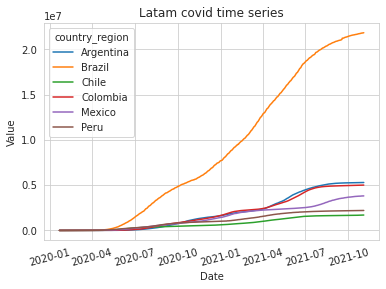

In [17]:
sns.lineplot(
    data=some_latam_countries_df,
    x="date",
    y="value",
    hue="country_region"
)

plt.xticks(rotation=15)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Latam covid time series");

#### Latam in global context

Top `n` countries.

In [18]:
top_countries_df = (
    processed_covid_df
    .select_columns(["country_region", "value"])
    .groupby(["country_region"])
    .aggregate("sum")
    .sort_values("value", ascending=False)
    .reset_index()
    .head(20)
    .transform_column(
        column_name="country_region",
        function=lambda x: "red" if x in countries else "lightblue",
        dest_column_name="color"
    )
)

top_countries_df.head()

,country_region,value,color
0,US,12121393193,lightblue
1,India,8292123869,lightblue
2,Brazil,5814374352,red
3,Russia,1962056598,lightblue
4,France,1882800988,lightblue


Plot to Latam in highlighted bars.

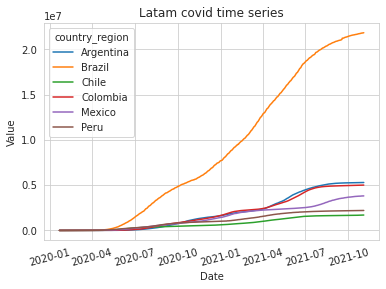

In [20]:
import final_project.visualization.visualize as visualize
visualize.covid_time_series(some_latam_countries_df)

In [22]:
visualize.top_countries(processed_covid_df, countries,11)

,country_region,value,color
0,US,12121393193,lightblue
1,India,8292123869,lightblue
2,Brazil,5814374352,red
3,Russia,1962056598,lightblue
4,France,1882800988,lightblue
5,United Kingdom,1804381811,lightblue
6,Turkey,1613367050,lightblue
7,Spain,1358747941,lightblue
8,Italy,1342417394,lightblue
9,Argentina,1277564288,red
